# Semantic Text Splitting
This notebook demonstrates different semantic text splitters. It will compare publicly available semantic chunking librarys and a self written one.
With these results we determine which one to use and build the text splitting & chunking step based on it.


## Setup

In [211]:
from IPython.display import display

import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass("OPENAI_API_KEY: ")


## Loading the file
We use the paper *Managing North-South Research Collaboration Projects During the COVID-19 Pandemic. An Empirical Study* for this example. This file is already preprocessed by the [Nougat](https://facebookresearch.github.io/nougat/)-model by Meta .


In [212]:
def print_pretty(data):
    if type(data) == list:
        for item in data:
            print(item)
    else:
        split_lines = data.split("\\n")
        for split_line in split_lines:
            print(split_line)
        
file_path = 'data/sulayman_corona.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()
data = lines[0]
data_semantic_text_splitter = lines[0]
data_semantic_splitter = lines[0]



## Preprocessing
Extract tables with their heading 


In [213]:
import re

def find_and_remove_patter(data, pattern):
    found_pattern = re.findall(pattern, data, re.DOTALL)
    print(f"Found {len(found_pattern)} patterns")
    for entry in found_pattern:
        data = re.sub(re.escape(entry), '', data)
    return data, found_pattern

# Define the regular expression pattern
pattern_table = r"\\begin{table}.*?\\end{table}"
pattern_tabulate = r"\\begin{tabular}.*?\\end{tabular}"

data, tables1 = find_and_remove_patter(data, pattern_table)
data, tables2 = find_and_remove_patter(data, pattern_tabulate)

tables = tables1 + tables2

print(f"Found {len(tables)} tables")


#filter out references 
def find_and_remove_references(data: str):
    search_array = [ "## References", "# References","**References**"]
    for search_term in search_array:
        if data.find(search_term) != -1:
            data = data.split(search_term)
            return data[0], data[1]

data, references = find_and_remove_references(data)

# Print the updated data
#print_pretty(data)
#print_pretty(tables1)


#Use for other packages
data_semantic_text_splitter = data
data_semantic_splitter =data


Found 6 patterns
Found 1 patterns
Found 7 tables


## Splitting into sentences

In [214]:
import nltk
nltk.download('punkt')

from nltk.tokenize import sent_tokenize
import pandas as pd
from tabulate import tabulate


sentences = sent_tokenize(data)
# Create a DataFrame with the sentences
df = pd.DataFrame({'Sentences': sentences})
print(tabulate(df, headers='keys', tablefmt='psql'))



+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|     | Sentences                                                          

[nltk_data] Downloading package punkt to /Users/philipp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Group the sentences together

In [215]:
def build_sentence_dict(sentences: list) -> dict:
    sentence_dict  = [{'sentence': x, 'index' : i} for i, x in enumerate(sentences)]
    return sentence_dict

def combine_sentences(sentences:dict, sentence_window=1):
    for i in range(len(sentences)):
        combined_sentence = ''
        for j in range(i - sentence_window, i):
            if j >= 0:
                combined_sentence += sentences[j]['sentence'] + ' '
        combined_sentence += sentences[i]['sentence']
        for j in range(i + 1, i + 1 + sentence_window):
            if j < len(sentences):
                combined_sentence += ' ' + sentences[j]['sentence']
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentence_dict = build_sentence_dict(sentences)
sentence_dict = combine_sentences(sentence_dict, sentence_window=1)
display(sentence_dict[3:6])

[{'sentence': 'Since then, a lot has changed, including the nature and dynamics of research collaboration.',
  'index': 3,
  'combined_sentence': 'The tools they used to manage their research projects remained virtually unchanged until the COVID-19 pandemic outbreak early in 2020. Since then, a lot has changed, including the nature and dynamics of research collaboration. How are researchers and project managers adapting to this change?'},
 {'sentence': 'How are researchers and project managers adapting to this change?',
  'index': 4,
  'combined_sentence': 'Since then, a lot has changed, including the nature and dynamics of research collaboration. How are researchers and project managers adapting to this change? Survey data, semi-structured interviews, and personal accounts from 102 respondents from 33 countries are used in this empirical study to investigate the impact of the pandemic on research collaboration projects.'},
 {'sentence': 'Survey data, semi-structured interviews, and pe

## Tokenize using TikToken

In [216]:
from tiktoken import Encoding, get_encoding, encoding_for_model


def tokenize_sentences(sentence_dict: dict, encoding_name: str) -> dict:
    encoding: Encoding = encoding_for_model(encoding_name)
    for sentence in sentence_dict:
        sentence['tokens'] = encoding.encode(sentence['combined_sentence'])
    return sentence_dict

sentence_dict = tokenize_sentences(sentence_dict, 'text-similarity-davinci-001')

display(sentence_dict[3:4])


[{'sentence': 'Since then, a lot has changed, including the nature and dynamics of research collaboration.',
  'index': 3,
  'combined_sentence': 'The tools they used to manage their research projects remained virtually unchanged until the COVID-19 pandemic outbreak early in 2020. Since then, a lot has changed, including the nature and dynamics of research collaboration. How are researchers and project managers adapting to this change?',
  'tokens': [464,
   4899,
   484,
   973,
   284,
   6687,
   511,
   2267,
   4493,
   6150,
   9826,
   21588,
   1566,
   262,
   7375,
   11008,
   12,
   1129,
   19798,
   5314,
   17645,
   1903,
   287,
   12131,
   13,
   4619,
   788,
   11,
   257,
   1256,
   468,
   3421,
   11,
   1390,
   262,
   3450,
   290,
   17262,
   286,
   2267,
   12438,
   13,
   1374,
   389,
   4837,
   290,
   1628,
   11663,
   35135,
   284,
   428,
   1487,
   30]}]

## Create Embeddings for the sentences

In [217]:
from langchain_openai import OpenAIEmbeddings

def embed_sentences(sentence_dict: dict, model_name: str = "text-embedding-ada-002") -> dict:
    oaiembeddings = OpenAIEmbeddings(model=model_name)
    embeddings = oaiembeddings.embed_documents([x['combined_sentence'] for x in sentence_dict])
    for i, sentence in enumerate(sentence_dict):
        sentence['combined_sentence_embedding'] = embeddings[i]
    return sentence_dict

sentence_dict = embed_sentences(sentence_dict)

display(sentence_dict[3:4])

[{'sentence': 'Since then, a lot has changed, including the nature and dynamics of research collaboration.',
  'index': 3,
  'combined_sentence': 'The tools they used to manage their research projects remained virtually unchanged until the COVID-19 pandemic outbreak early in 2020. Since then, a lot has changed, including the nature and dynamics of research collaboration. How are researchers and project managers adapting to this change?',
  'tokens': [464,
   4899,
   484,
   973,
   284,
   6687,
   511,
   2267,
   4493,
   6150,
   9826,
   21588,
   1566,
   262,
   7375,
   11008,
   12,
   1129,
   19798,
   5314,
   17645,
   1903,
   287,
   12131,
   13,
   4619,
   788,
   11,
   257,
   1256,
   468,
   3421,
   11,
   1390,
   262,
   3450,
   290,
   17262,
   286,
   2267,
   12438,
   13,
   1374,
   389,
   4837,
   290,
   1628,
   11663,
   35135,
   284,
   428,
   1487,
   30],
  'combined_sentence_embedding': [0.005322070729592709,
   -0.021677227469364384,
   -0.00

## Calculate distances


In [218]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_distance(sentence_dict: dict) -> dict:
    distances = []
    for i in range(len(sentence_dict) - 1):
        embedding_current = sentence_dict[i]['combined_sentence_embedding']
        embedding_next = sentence_dict[i + 1]['combined_sentence_embedding']
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        distance = 1 - similarity
        distances.append(distance)
        sentence_dict[i]['distance_to_next'] = distance
    return distances, sentence_dict

distances, sentence_dict = calculate_distance(sentence_dict)
display(distances[:5] )
display(len(distances))

[0.0067538819456109955,
 0.029197444296526376,
 0.09669181383763625,
 0.05462047009736393,
 0.04237522892671475]

264

## Show the results

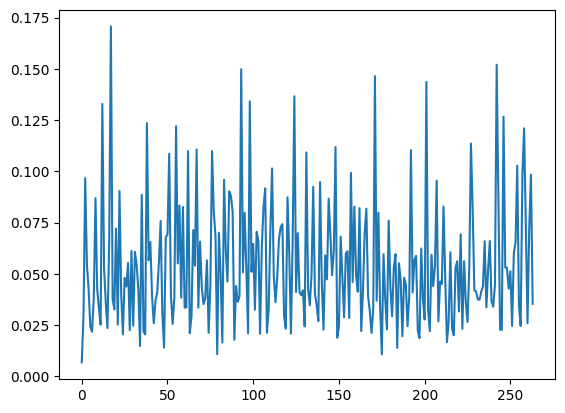

In [219]:
import matplotlib.pyplot as plt

plt.plot(distances);

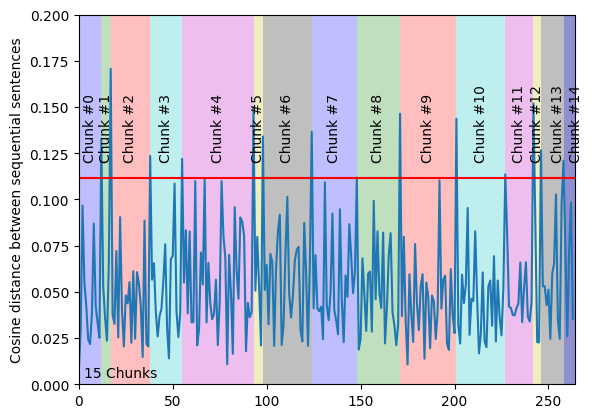

In [220]:
import numpy as np
def plot_distances(distances: list):
    plt.plot(distances);

    y_upper_bound = .2
    plt.ylim(0, y_upper_bound)
    plt.xlim(0, len(distances))

    # We need to get the distance threshold that we'll consider an outlier
    # We'll use numpy .percentile() for this
    breakpoint_percentile_threshold = 95
    breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
    plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

    # Then we'll see how many distances are actually above this one
    num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
    plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

    # Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
    indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

    # Start of the shading and text
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, breakpoint_index in enumerate(indices_above_thresh):
        start_index = 0 if i == 0 else indices_above_thresh[i - 1]
        end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

        plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
        plt.text(x=np.average([start_index, end_index]),
                y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                s=f"Chunk #{i}", horizontalalignment='center',
                rotation='vertical')

    # # Additional step to shade from the last breakpoint to the end of the dataset
    if indices_above_thresh:
        last_breakpoint = indices_above_thresh[-1]
        if last_breakpoint < len(distances):
            plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
            plt.text(x=np.average([last_breakpoint, len(distances)]),
                    y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                    s=f"Chunk #{i+1}",
                    rotation='vertical')

    plt.ylabel("Cosine distance between sequential sentences")
    plt.show()

plot_distances(distances)

## Create Chunks


In [221]:
def split_chunks(sentence_dict: dict, distances: list, threshold: int = 95) -> dict:
    breakpoint_distance_threshold = np.percentile(distances, threshold) # If you want more chunks, lower the percentile cutoff
    indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list
    start_index = 0
    chunks = []
    for index in indices_above_thresh:
        end_index = index
        group = sentence_dict[start_index:end_index]
        combined_text = ' '.join([d['sentence'] for d in group])
        chunks.append(combined_text)
        start_index = index + 1
    if start_index < len(sentences):
        combined_text = ' '.join([d['sentence'] for d in sentence_dict[start_index:]])
        chunks.append(combined_text)
    return chunks
        
chunks = split_chunks(sentence_dict, distances, 95)

display(f"#Chunks: {len(chunks)}")

token_len = 0
for sentence in sentence_dict:
    token_len += len(sentence['tokens'])
display(f"Token Length: {token_len}")
display(f"Token Length per chunk: {token_len / len(chunks)}")


chunk_size = int(round(token_len / len(chunks)))



df = pd.DataFrame({'Chunks': chunks})
print(tabulate(df, headers='keys', tablefmt='psql'))


'#Chunks: 15'

'Token Length: 36086'

'Token Length per chunk: 2405.733333333333'

+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Semantic-Text-Splitter Package

We now look at the package [semantic-text-splitter](https://pypi.org/project/semantic-text-splitter/)

In [222]:
from semantic_text_splitter import TextSplitter

text_splitter: TextSplitter = TextSplitter.from_tiktoken_model("gpt-4")
chunks_sem_text_splitter = text_splitter.chunks(data_semantic_text_splitter, chunk_capacity=chunk_size)

display(f"#Chunks: {len(chunks_sem_text_splitter)}")

df = pd.DataFrame({'Chunks': chunks_sem_text_splitter})
print(tabulate(df, headers='keys', tablefmt='psql'))

'#Chunks: 6'

+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [223]:
from semantic_text_splitter import MarkdownSplitter

markdown_splitter: TextSplitter = MarkdownSplitter.from_tiktoken_model("gpt-4")
chunks_sem_text_splitter_md = markdown_splitter.chunks(data_semantic_text_splitter, chunk_capacity=chunk_size)

display(f"#Chunks: {len(chunks_sem_text_splitter_md)}")
df = pd.DataFrame({'Chunks': chunks_sem_text_splitter_md})
print(tabulate(df, headers='keys', tablefmt='psql'))

'#Chunks: 6'

+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Semantic-Text-Splitter Package

We now look at the package [semantic-split](https://github.com/agamm/semantic-split)

In [224]:
!python -m spacy download en_core_web_sm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [225]:
from semantic_split import SimilarSentenceSplitter, SentenceTransformersSimilarity, SpacySentenceSplitter

model = SentenceTransformersSimilarity()
sentence_splitter = SpacySentenceSplitter()
splitter = SimilarSentenceSplitter(model, sentence_splitter)
res = splitter.split(data_semantic_splitter)

display(f"#Chunks: {len(res)}")
df = pd.DataFrame({'Chunks': res})
print(tabulate(df, headers='keys', tablefmt='psql'))


'#Chunks: 71'

+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------